Implement Variational Autoencoder (VAE) to generate new images

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (-1, 28 * 28))
x_test = np.reshape(x_test, (-1, 28 * 28))

# Set latent space dimension
latent_dim = 2
input_shape = 784

# Redefine Encoder and Decoder as separate models
encoder_input = Input(shape=(input_shape,))
h_enc = Dense(256, activation='relu')(encoder_input)
z_mean_enc = Dense(latent_dim)(h_enc)
z_log_var_enc = Dense(latent_dim)(h_enc)



In [10]:
# Sampling layer function
def sampling(args):
    z_mean, z_log_var = args
    # Use keras.backend.random_normal which is compatible with KerasTensors within a layer
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Apply the sampling function using a Lambda layer in the encoder
z_enc = Lambda(sampling)([z_mean_enc, z_log_var_enc])

# Define the encoder model
encoder_model = Model(encoder_input, [z_mean_enc, z_log_var_enc, z_enc], name="encoder")


# Define the decoder model
decoder_input = Input(shape=(latent_dim,))
decoder_hidden = Dense(256, activation='relu')(decoder_input)
decoder_output = Dense(input_shape, activation='sigmoid')(decoder_hidden)
decoder_model = Model(decoder_input, decoder_output, name="decoder")




In [11]:
# Define custom VAE model inheriting from tf.keras.Model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Encoder outputs z_mean, z_log_var, and z (sampled latent vector)
        z_mean, z_log_var, z = self.encoder(inputs)
        # Decoder outputs the reconstruction
        reconstruction = self.decoder(z)

        # Calculate reconstruction loss within the model's graph
        # Use from_logits=False as the output is sigmoid
        reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, reconstruction)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss) * input_shape

        # Calculate KL divergence loss within the model's graph
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # Add the total loss to the model
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss) # Add loss to the model using self.add_loss

        # The call method typically returns the model's output, which is the reconstruction
        return reconstruction

    # Override train_step for more control over the training process and metrics
    def train_step(self, data):
        # Unpack the data. For VAE, inputs are typically also the targets.
        x = data

        with tf.GradientTape() as tape:
            # Forward pass: Encode and decode
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # Calculate losses inside the tape for gradient computation
            reconstruction_loss = tf.keras.losses.binary_crossentropy(x, reconstruction)
            reconstruction_loss = tf.reduce_mean(reconstruction_loss) * input_shape

            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Return metrics to be displayed during training
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

    # Override test_step for evaluation
    def test_step(self, data):
         # Unpack the data.
        x = data

        # Forward pass: Encode and decode
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        # Calculate losses
        reconstruction_loss = tf.keras.losses.binary_crossentropy(x, reconstruction)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss) * input_shape

        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        total_loss = reconstruction_loss + kl_loss

        # Return metrics
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}


# Instantiate the custom VAE model
vae = VAE(encoder_model, decoder_model)

# Compile the custom VAE model
# No need to specify loss function here, it's handled in the model's call/train_step
vae.compile(optimizer='adam')

# Train the custom VAE model
# Pass only the input data, as targets are implicitly the inputs for VAE
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test,))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - kl_loss: 7.2188 - loss: 202.5077 - reconstruction_loss: 195.2890 - val_kl_loss: 3.5134 - val_loss: 179.2506 - val_reconstruction_loss: 175.7372
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 3.1210 - loss: 167.9632 - reconstruction_loss: 164.8421 - val_kl_loss: 3.3459 - val_loss: 170.2480 - val_reconstruction_loss: 166.9021
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.1354 - loss: 163.6455 - reconstruction_loss: 160.5101 - val_kl_loss: 3.3270 - val_loss: 164.1330 - val_reconstruction_loss: 160.8060
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.2029 - loss: 161.2320 - reconstruction_loss: 158.0291 - val_kl_loss: 3.2356 - val_loss: 159.3598 - val_reconstruction_loss: 156.1242
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 3.2865 - loss: 159.3503 - reconstruction_loss: 156.0637 - val_kl_loss: 3.2265 - val_loss: 155.8038 - val_reconstruction_loss: 152.5773
Epoch 6/30


Generate New Digits from Latent Space



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

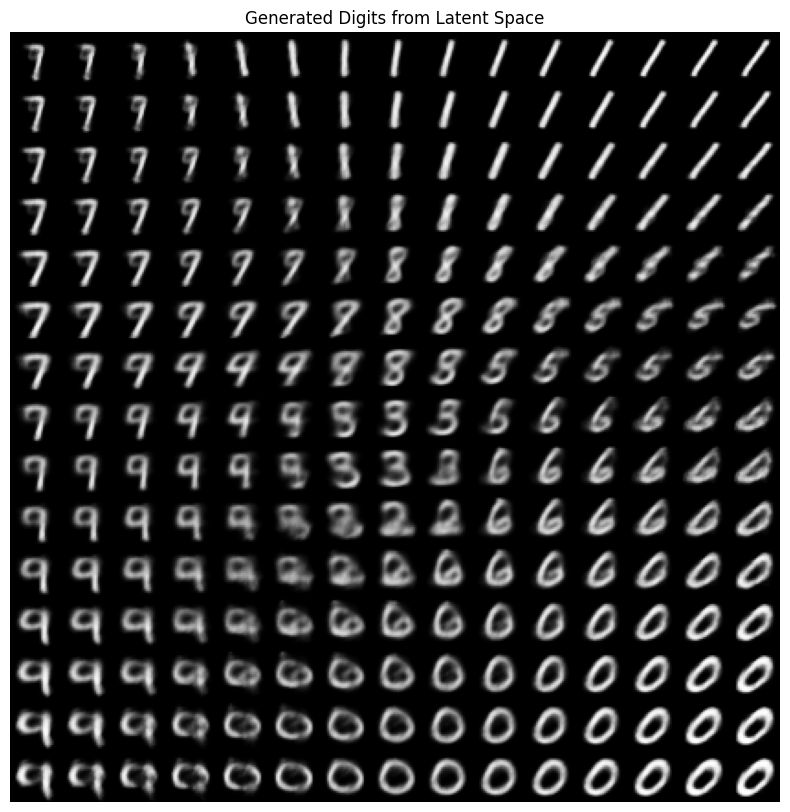

In [12]:
# Define decoder separately for generation
z_input = Input(shape=(latent_dim,))
decoder_h = Dense(256, activation='relu')(z_input)
decoder_out = Dense(784, activation='sigmoid')(decoder_h)
decoder = Model(z_input, decoder_out)

# Set weights from VAE decoder part
decoder.set_weights(vae.get_weights()[-4:])  # Use last 4 layers from VAE

# Generate images from latent space
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.title("Generated Digits from Latent Space")
plt.show()
